In [55]:
import os
import ee
import geemap
import geopandas as gpd

ee.Initialize()
Map = geemap.Map()

In [56]:
qq_shp = gpd.read_file('../data/external/usfs_stands/oregon_quarter_quads_sample.geojson')

In [3]:
cell = qq_shp[qq_shp.CELL_ID == 108243].geometry[0]

In [4]:
cell.bounds

(-119.43750122498258, 44.31249826022575, -119.37500115923605, 44.3749981924306)

In [5]:
geom = ee.Geometry.Rectangle(*cell.bounds)

year = 2009

collection = ee.ImageCollection('USDA/NAIP/DOQQ')\
               .filter(ee.Filter.date(f'{year}-01-01', f'{year}-12-31'))\
               .filter(ee.Filter.bounds(geom))

In [6]:
def utcfromtimestamp(timestamp):
    from datetime import datetime
    return datetime.utcfromtimestamp(timestamp/1000)

mtd = collection.getInfo()
end_date = max([utcfromtimestamp(item['properties']['system:time_end']) for item in mtd['features']])
start_date = min([utcfromtimestamp(item['properties']['system:time_start']) for item in mtd['features']])

In [7]:
print(len(mtd['features']))
print(start_date, end_date)

9
2009-07-11 00:00:00 2009-07-24 00:00:00


In [8]:
qq = collection.select(['R', 'G', 'B']).median().clip(geom);
trueColorVis = dict(
  min=0.0,
  max=255.0,
);

In [9]:
Map.centerObject(geom)
Map.addLayer(qq, trueColorVis, 'Mosaic')

In [10]:
# geemap.ee_export_image(
#       image, 
#       'test.tif', 
#       scale=30, 
#       crs='EPSG:4326', 
#       # region=geom.bounds(), 
#       file_per_band=False, 
#       cloud_optimized=True)


In [11]:
# import rasterio
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Open the COG
# with rasterio.open('../data/external/sample_tiles/oregon/naip/2009/108243_naip_2009_2.tif') as src:
#     plt.imshow(src.read(1), cmap='terrain')
#     plt.show()
#     # print(src.read(1))

In [12]:
def split_bbox(dim, bbox_to_split):
    import numpy as np
    
    xmin, ymin, xmax, ymax = bbox_to_split
    
    w = (xmax-xmin)/dim
    l = (ymax-ymin)/dim
    
    # For testing
    #cols = ['xmin', *[f'xmin + w*{dim + 1}' for dim in range(dim - 1)], 'xmax']
    #rows = ['ymin', *[f'ymin + l*{dim + 1}' for dim in range(dim - 1)], 'ymax']
    
    cols = [xmin, *[xmin + w*(dim + 1) for dim in range(dim - 1)], xmax]
    rows = [ymin, *[ymin + l*(dim + 1) for dim in range(dim - 1)], ymax]
    
    coords = np.array(np.meshgrid(cols, rows)).T
    
    bbox_splitted = []
    for i in range(dim):
        bbox_splitted.append([
            np.array(
                [coords[i][j], coords[i + 1][k]]
            ).flatten()
            for j,k in zip(range(dim), range(1, dim + 1))
        ])
    
    # Flatten result
    return np.array([x for sbl in bbox_splitted for x in sbl])
    

In [13]:
grid = [ee.Geometry.Rectangle(*bbox) for bbox in split_bbox(3, cell.bounds)]    

In [14]:
for index, geom_i in enumerate(grid):
    Map.addLayer(geom_i, trueColorVis, f'geom_{index}')

In [15]:
Map

Map(center=[44.34375035635465, -119.40625119210932], controls=(WidgetControl(options=['position', 'transparent…

In [118]:
for index, i in enumerate(range(1, len(grid) + 1)):
    print(i, index)

1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24


In [24]:
import numpy as np

xmin, ymin, xmax, ymax = cell.bounds

w = (xmax-xmin)/9
l = (ymax-ymin)/9

cols = [xmin, xmin + w, xmin + 2*w, xmax]
rows = [ymin, ymin + l, ymin + 2*l, ymax]

cols = ['xmin', 'xmin + w', 'xmin + 2*w', 'xmax']	
rows = ['ymin', 'ymin + l', 'ymin + 2*l', 'ymax']

coords = np.array(np.meshgrid(cols, rows)).T.tolist()

In [25]:
sq1 = [coords[0][0], coords[1][1]]
sq2 = [coords[1][0], coords[2][1]]
sq3 = [coords[2][0], coords[3][1]]
sq4 = [coords[0][1], coords[1][2]]
sq5 = [coords[1][1], coords[2][2]]
sq6 = [coords[2][1], coords[3][2]]
sq7 = [coords[0][2], coords[1][3]]
sq8 = [coords[1][2], coords[2][3]]
sq9 = [coords[2][2], coords[3][3]]

print(sq9)

[['xmin + 2*w', 'ymin + 2*l'], ['xmax', 'ymax']]


In [26]:
dim = 3
cols = ['xmin', *[f'xmin + w*{dim + 1}' for dim in range(dim -1)], 'xmax']	
rows = ['ymin', *[f'ymin + l*{dim + 1}' for dim in range(dim -1)], 'ymax']
coords = np.array(np.meshgrid(cols, rows)).T.tolist()
# coords = coords.tolist()
for i in range(dim):
    print(list((coords[i][j], coords[i + 1][k]) for j,k in zip(range(dim), range(1,dim+1))))



[(['xmin', 'ymin'], ['xmin + w*1', 'ymin + l*1']), (['xmin', 'ymin + l*1'], ['xmin + w*1', 'ymin + l*2']), (['xmin', 'ymin + l*2'], ['xmin + w*1', 'ymax'])]
[(['xmin + w*1', 'ymin'], ['xmin + w*2', 'ymin + l*1']), (['xmin + w*1', 'ymin + l*1'], ['xmin + w*2', 'ymin + l*2']), (['xmin + w*1', 'ymin + l*2'], ['xmin + w*2', 'ymax'])]
[(['xmin + w*2', 'ymin'], ['xmax', 'ymin + l*1']), (['xmin + w*2', 'ymin + l*1'], ['xmax', 'ymin + l*2']), (['xmin + w*2', 'ymin + l*2'], ['xmax', 'ymax'])]


In [100]:
cols

['xmin', 'xmin + w*1', 'xmin + w*2', 'xmax']

In [85]:
from geemap import ee_export_image

# ee_export_image(qq, 'test.tif', scale=1, file_per_band=False)

Generating URL ...
An error occurred while downloading.
Total request size (1307359494 bytes) must be less than or equal to 50331648 bytes.


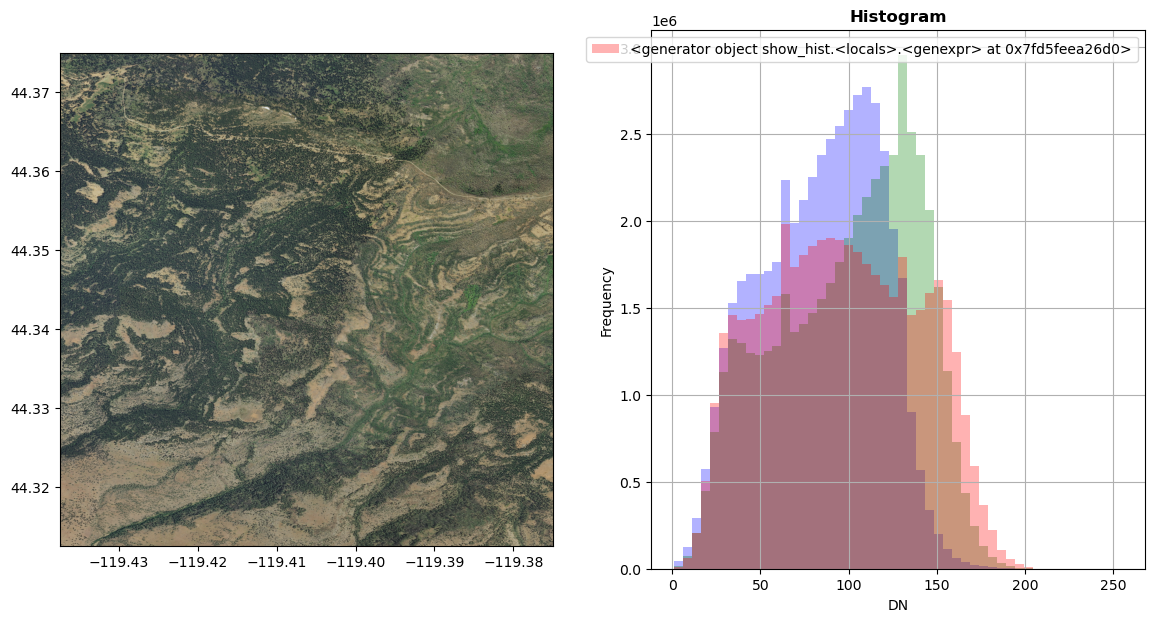

In [47]:
import rasterio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt

%matplotlib inline
# Open the COG
with rasterio.open('../data/processed/NAIP/2011/108243_OR_NAIP_DOQQ_2011/'\
                   '108243_OR_NAIP_DOQQ_2011-cog.tif') as src:
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.show()

In [10]:
import rasterio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
%matplotlib inline

tifpath = '../data/processed/3DEP/108243_3DEP_10mDEM/108243_3DEP_10mDEM-cog.tif'
grid = Grid.from_raster(tifpath)

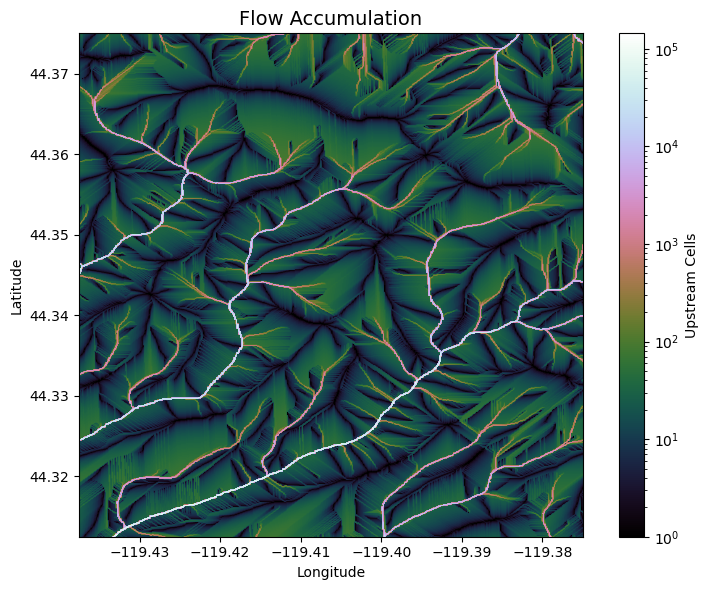

In [11]:
with rasterio.open(tifpath) as src:
    acc = src.read(4)
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(acc, extent=grid.extent, zorder=2,
                   cmap='cubehelix',
                   norm=colors.LogNorm(1, acc.max()),
                   interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='Upstream Cells')
    plt.title('Flow Accumulation', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

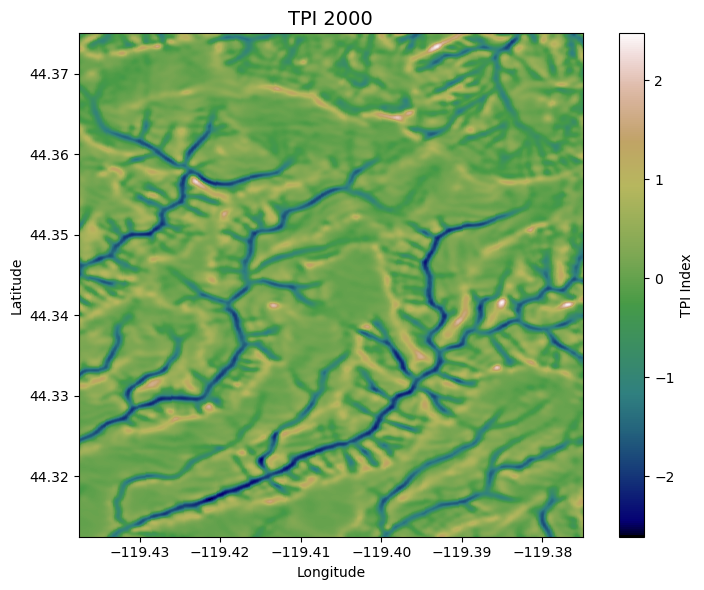

In [12]:
with rasterio.open(tifpath) as src:
    img = src.read(5)
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(img, extent=grid.extent, zorder=2,
                   cmap='gist_earth',
                   interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='TPI Index')
    plt.title('TPI 2000', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

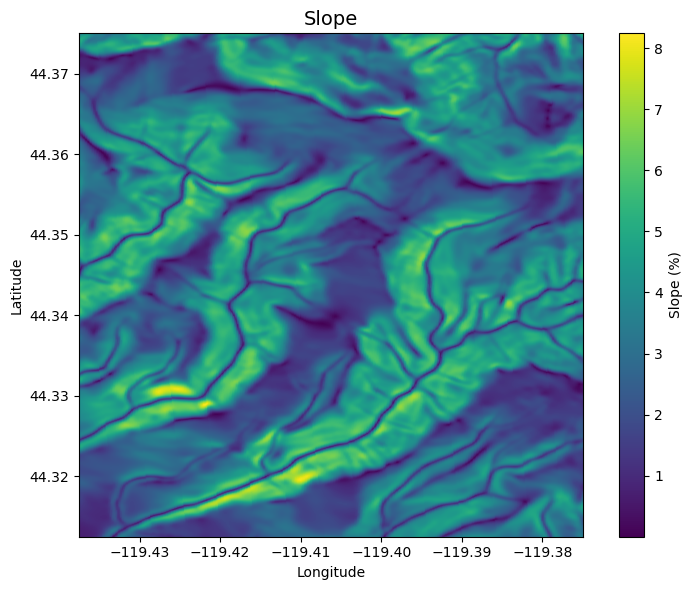

In [13]:
with rasterio.open(tifpath) as src:
    img = src.read(2)
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(img, extent=grid.extent, zorder=2,
                   interpolation='bilinear')
    plt.colorbar(im, ax=ax, label='Slope (%)')
    plt.title('Slope', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

6.0


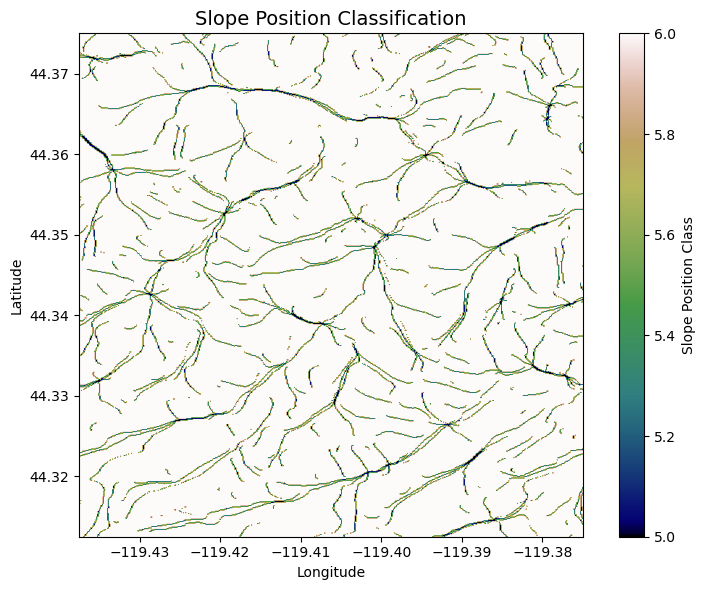

In [14]:
with rasterio.open(tifpath) as src:
    img = src.read(7)
    print(img.max())
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(img, extent=grid.extent, zorder=2,
                   cmap='gist_earth')
    plt.colorbar(im, ax=ax, label='Slope Position Class')
    plt.title('Slope Position Classification', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

10.0


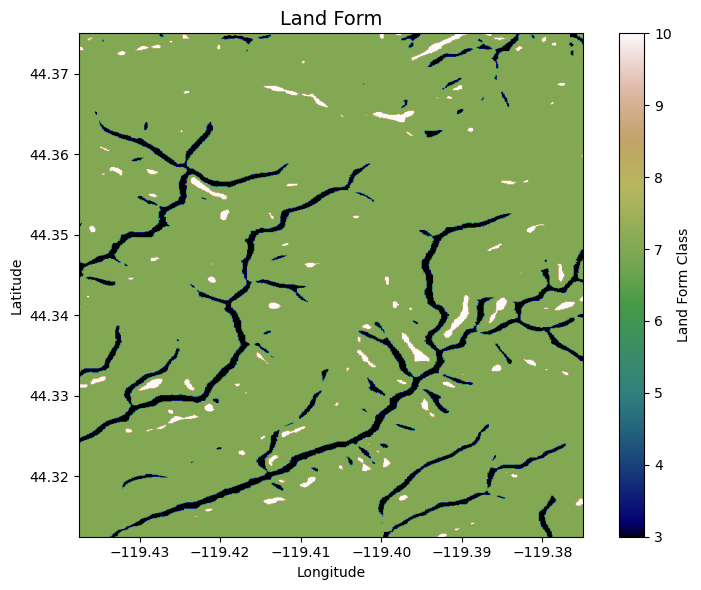

In [15]:
with rasterio.open(tifpath) as src:
    img = src.read(8)
    print(img.max())
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(img, extent=grid.extent, zorder=2,
                   cmap='gist_earth')
    plt.colorbar(im, ax=ax, label='Land Form Class')
    plt.title('Land Form', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()

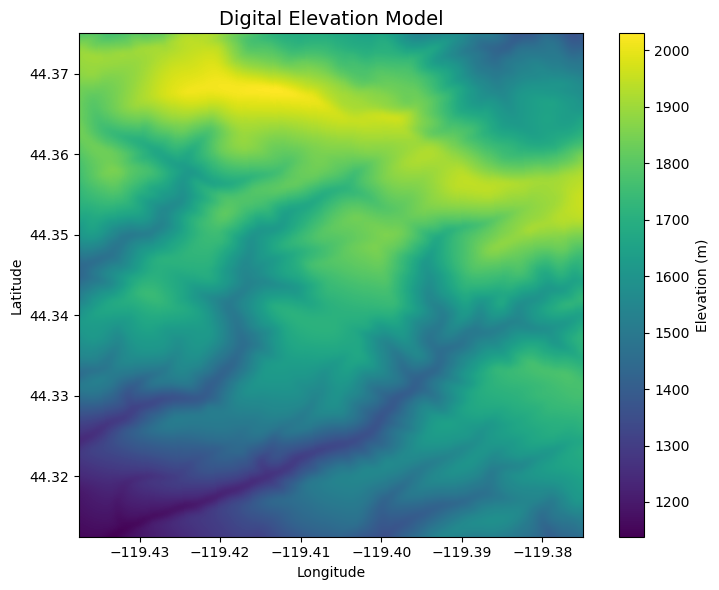

In [16]:
with rasterio.open(tifpath) as src:
    img = src.read(1)
    fig, ax = plt.subplots(figsize=(8,6))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(img, extent=grid.extent, zorder=2)
    plt.colorbar(im, ax=ax, label='Elevation (m)')
    plt.title('Digital Elevation Model', size=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()